# Model Architecture

In [1]:
import numpy as np
import torch
torch.manual_seed(0)
np.random.seed(0)
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class net(nn.Module):
  """
  This is the overall class implementing the CNN architecture
  """

  def __init__(self,inp_channels,num_filters,bw,neurons_2nd_last_lyr,neurons_last_lyr,relu):
    """
    inp_channels: Number of channels in your image for eg RGB has 3, Black and White has 1
    Num_Filters: How many filters should be used in the first convolutional layer
    bw: is the image black and white? [Boolean]
    """

    super(net, self).__init__()
    self.inp_channels = inp_channels
    self.num_filters=num_filters
    self.bw = bw
    self.neurons1 = neurons_2nd_last_lyr
    self.neurons2 = neurons_last_lyr
    self.relu = relu

    self.conv1 = nn.Conv2d(self.inp_channels,num_filters,5,stride=1,padding=2)   # Adjust the Filter size and padding accordingly
    self.pool1 = nn.MaxPool2d(2,stride=2) ## image dimensions halved
    self.conv2 = nn.Conv2d(self.num_filters,self.num_filters*2,5,stride=1,padding=0)
    self.pool2 = nn.MaxPool2d(2,stride=2) ## image dimensions halved
    ## Non Linearities are added using nn.Functional

    self.fc1 = nn.Linear(432,self.neurons1)   ## base this on input image dimension
    self.fc2 = nn.Linear(self.neurons1,self.neurons2)
    self.fc3 = nn.Linear(self.neurons2,11)
    

  def forward(self,X):
    """
    Forward Loop of CNN.
    X is the input with dimension as: batch_size x input_channels x height x width
    """
    if self.bw:
      X = torch.unsqueeze(X,1)   ## in case your input image is 2D use this line to convert your 2D image into 3 Dimensional form [1 x height x width]
    
    if self.relu:
      X = F.relu(self.conv1(X))   # B_sizex6x32x32
      X = self.pool1(X)  ## B_sizex6x16x16
      X = F.relu(self.conv2(X))  ## B_sizex12x12x12
      X = self.pool2(X) ## B_sizex12x6x6

      X = X.view(-1,432)  ## B_sizex432
      X = F.relu(self.fc1(X))
      X = F.relu(self.fc2(X))
      X = torch.sigmoid(self.fc3(X))
    
    else:
      X = torch.sigmoid(self.conv1(X))   # 6x32x32
      X = self.pool1(X)  ## 6x16x16
      X = torch.sigmoid(self.conv2(X))  ## 12x12x12
      X = self.pool2(X) ## 12x6x6

      X = X.view(-1,432)  # Flatten the input before inputting into FC layers  432
      X = torch.sigmoid(self.fc1(X))
      X = torch.sigmoid(self.fc2(X))
      X = torch.sigmoid(self.fc3(X))


    return X 

In [31]:
from torchsummary import summary
model = net(40,6,False,216,54,True)
model.to(device)
summary(model,input_size=(40,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]           6,006
         MaxPool2d-2            [-1, 6, 16, 16]               0
            Conv2d-3           [-1, 12, 12, 12]           1,812
         MaxPool2d-4             [-1, 12, 6, 6]               0
            Linear-5                  [-1, 216]          93,528
            Linear-6                   [-1, 54]          11,718
            Linear-7                   [-1, 11]             605
Total params: 113,669
Trainable params: 113,669
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.16
Forward/backward pass size (MB): 0.08
Params size (MB): 0.43
Estimated Total Size (MB): 0.67
----------------------------------------------------------------


# Data Setup

In [4]:
import numpy as np
import torch
base = "/content/drive/MyDrive/data_soli_dictionaries/"
from google.colab import drive
drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {}".format(device))

Mounted at /content/drive
Using cuda


In [42]:
import pickle
from random import sample
def get_data(train,number_of_frames):
  
  if train:
    with open(base+'train.pickle', 'rb') as f:
        data = pickle.load(f)
  else:
    with open(base+'test.pickle', 'rb') as f:
      data = pickle.load(f)

  X = []
  y = []
  keys = np.arange(11)

  for key in keys:
    gesture_data = data[key]
    for i in range(len(gesture_data)):
      datapt_arr = gesture_data[i]
      datapt= (datapt_arr[0]+datapt_arr[1]+datapt_arr[2]+datapt_arr[3])/4
      num_frames = np.shape(datapt)[0]

      if num_frames < number_of_frames:
          size = number_of_frames - num_frames
          use = np.zeros((size,32,32))
          datapt = np.vstack((datapt,use))      ## subsampling and extension so that finally all sequences are of length 40

      if num_frames > number_of_frames:
          datapt = datapt[np.sort(np.random.randint(datapt.shape[0],size=number_of_frames)),:,:]
          

      minimum = datapt.min()
      maximum = datapt.max()                                ## Linear Normalization of pixel values to 0-1
      datapt = (datapt-minimum)/((maximum-minimum))  

      X.append(datapt)
      y_temp = np.zeros(11)
      y_temp[key]=1
      y.append(y_temp)
  return X,y

In [5]:
from torch.utils.data import Dataset

class SoliData(Dataset):
  def __init__(self, train,X_train,y_train,X_test,y_test,X_val,y_val):
        if train=="Train":
            self.data= X_train               # in this just define dataset of train and test after split into self.data
            self.target = y_train
        elif train=="Test":
            self.data = X_test
            self.target = y_test  
        else:
            self.data = X_val
            self.target = y_val             

  def __getitem__(self, index):
        target = self.target[index]                                                     # gets data point sequentially
        x = self.data[index]
        return x, target

  def __len__(self):
        return len(self.data)                                                      # gets number of datapoints

# Training Setup

In [6]:
import torch
import torch.nn as nn
import torch.optim as opti
import torch.nn.functional as func
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import statistics

def visualization(loss_arr,valloss,epo):
  x = np.linspace(1,epo,epo)
  plt.plot(x,loss_arr, label='Training Loss')
  plt.plot(x,valloss,label='Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.title('Training Curve')
  plt.legend()
  plt.show()

def train_single_epoch(lr,criterion,optimizer,device,nnet,trainloader,bsize,loss,valloader):
  nnet.train()                        ## a pytorch routine it is to turn ON some advanced layers which were turned OFF during testing  
  tloss =0
  for index,(x,y) in enumerate(trainloader):
    x= x.to(device).float()
    if loss == 'CrossEntropy':
      y = y.to(device).long()
    else:
      y = y.to(device).float()
    optimizer.zero_grad()          ## zeroing the gradients to nullify the effects of previous iterations
    pred_y = nnet(x)
    loss = criterion(pred_y,y)
    loss.backward()
    optimizer.step()
    tloss += loss.item() 
  tloss /= index

  nnet.eval()
  vloss =0
  

  with torch.no_grad():
    for index,(x,y) in enumerate(valloader):
      x= x.to(device).float()
      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()
      pred_y = nnet(x)
      loss = criterion(pred_y,y)
      vloss += loss.item()
  vloss /= index

    

  return tloss,vloss

def training(nnet,lr, epochs, batch_size,loss,mom,trainset,adaptive,sgd,valset,verbose):
  print('Data Setup Started')
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
  valloader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)
  
  print('Data Setup Completed')

  print('Building model')
  nnet = nnet.to(device)
  if device == 'cuda':
      nnet = torch.nn.DataParallel(nnet)                                           ## for using multiple GPUs
      cudnn.benchmark = True

  if loss == 'CrossEntropy':
    criterion = nn.CrossEntropyLoss()
  else:                                                                            ## choice of loss function
    criterion = nn.MSELoss()

  if sgd:
    optimizer = opti.SGD(nnet.parameters(), lr,mom) 
  else:
    optimizer = opti.Adam(nnet.parameters(), lr) 

  trainloss = []
  valloss = []
  for epoch in range(epochs):
    l,vl= train_single_epoch(lr,criterion,optimizer,device,nnet,trainloader,batch_size,loss,valloader) 

    if sgd:
      if adaptive:
        if epoch == 0.7*epochs:
          lr = 0.1*lr
          optimizer = opti.SGD(nnet.parameters(),lr,mom) 

    
    trainloss.append(l)
    valloss.append(vl)
    if verbose:
      print("The loss was "+str(l))
  
  visualization(trainloss,valloss,epochs)

  print("Training Completed.")
  return nnet

def testing(testset,nnet,device,loss):
  if loss == 'CrossEntropy':
    criterion = nn.CrossEntropyLoss()
  else:                                                                            ## choice of loss function
    criterion = nn.MSELoss()
  testloader = DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
  nnet.eval()                     ## a pytorch routine it is to turn OFF some advanced layers during testing   
  correct = 0
  total = 0
  with torch.no_grad():          ## turn OFF autograd
    for index,(x,y) in enumerate(testloader):
      total = total + 1
      x= x.to(device).float()

      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()

      pred_ysf = nnet(x)
      pred_y = torch.max(pred_ysf,1)[1][0]
      check_y = torch.max(y,1)[1][0]    ## to get the index of maximum value
      if (pred_y) == (check_y) :
        correct = correct +1
  return (correct/total)

In [7]:
from sklearn.metrics import confusion_matrix
def testing_conf(testset,nnet,device,loss):
  predictions = []
  actual = []
  if loss == 'CrossEntropy':
    criterion = nn.CrossEntropyLoss()
  else:                                                                            ## choice of loss function
    criterion = nn.MSELoss()
  testloader = DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)
  nnet.eval()                     ## a pytorch routine it is to turn OFF some advanced layers during testing   
  correct = 0
  total = 0
  with torch.no_grad():          ## turn OFF autograd
    for index,(x,y) in enumerate(testloader):
      total = total + 1
      x= x.to(device).float()

      if loss == 'CrossEntropy':
        y = y.to(device).long()
      else:
        y = y.to(device).float()

      pred_ysf = nnet(x)
      pred_y = torch.max(pred_ysf,1)[1][0]
      check_y = torch.max(y,1)[1][0]    ## to get the index of maximum value
      predictions.append(pred_y.item())
      actual.append(check_y.item())
      if (pred_y) == (check_y) :
        correct = correct +1
  conf = confusion_matrix(actual,predictions)
  return (correct/total),conf 

# Experimentation

 ## Unpruned data set



In [43]:
X_train, y_train = get_data(True,40)
X_test_use, y_test_use = get_data(False,40)

In [44]:
from sklearn.model_selection import train_test_split
X_val =[]
y_val =[]
X_test=[]
y_test=[]
count = 124
for i in range(11):
  val_X,test_X,val_y,test_y = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],test_size=0.50,random_state=2)
  X_val.extend(val_X)
  X_test.extend(test_X)
  y_val.extend(val_y)
  y_test.extend(test_y)

Data Setup Started
Data Setup Completed
Building model


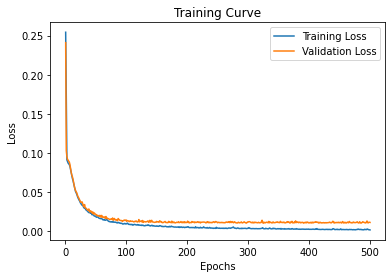

Training Completed.
0.9369501466275659
[[57  0  0  2  0  0  0  0  0  0  3]
 [ 0 59  1  0  0  0  0  0  2  0  0]
 [ 2  0 56  2  0  0  0  0  0  0  2]
 [10  0  1 51  0  0  0  0  0  0  0]
 [ 0  1  0  2 58  1  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  3  0]
 [ 0  0  0  0  0  3 58  1  0  0  0]
 [ 0  0  0  0  0  0  0 62  0  0  0]
 [ 0  0  0  0  1  0  0  0 61  0  0]
 [ 0  0  0  0  1  2  0  0  0 59  0]
 [ 3  0  0  0  0  0  0  0  0  0 59]]


In [45]:
model1 = net(40,6,False,216,54,True)  ## 1st
model1 = training(model1,0.0003,500,64,'MSE',0.9,SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val),True,False,SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),False)
accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print(accu)
print(conf)

In [ ]:
torch.save(model1,"/content/drive/MyDrive/saved_models/Modified_LeNet_RDI_CPU_93.pkl")

In [ ]:
best_model = torch.load("/content/drive/MyDrive/saved_models/Modified_LeNet_RDI_CPU_93.pkl")

In [ ]:
accu1, conf1 = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print((accu1+accu2)/2)
print(conf1+conf2)

0.9310850439882697
[[111   0   2   3   0   0   0   0   0   0   8]
 [  0 119   2   0   1   0   0   0   0   2   0]
 [  3   1 113   3   1   0   0   0   1   1   1]
 [ 20   0   4  96   0   0   0   0   1   0   3]
 [  0   2   2   1 119   0   0   0   0   0   0]
 [  0   0   0   0   0 120   3   0   0   1   0]
 [  0   0   0   0   0   4 118   2   0   0   0]
 [  0   0   0   0   0   0   0 124   0   0   0]
 [  0   2   0   0   1   0   0   0 119   2   0]
 [  0   0   0   0   4   5   0   0   2 113   0]
 [  6   0   0   0   0   0   0   0   0   0 118]]


#### New user testing

In [13]:
import pickle
from random import sample
def get_data_user(train,number_of_frames,user_number):
  base_n = "/content/drive/MyDrive/data_soli_userwise_dictionaries/"
  users = [2,3,5,6,8,9,10,11,12,13]
  with open(base_n+'train.pickle', 'rb') as f:
    data_tr = pickle.load(f)
  with open(base_n+'test.pickle', 'rb') as f:
    data_te = pickle.load(f)

  X = []
  y = []
  
  keys = np.arange(11)
  for data in [data_tr,data_te]:
    for key in keys:
      for user in users:

        gesture_data = data[user][key]

        for i in range(len(gesture_data)):
          datapt_arr = gesture_data[i]
          datapt= (datapt_arr[0]+datapt_arr[1]+datapt_arr[2]+datapt_arr[3])/4
          num_frames = np.shape(datapt)[0]

          if num_frames < number_of_frames:
              size = number_of_frames - num_frames
              use = np.zeros((size,32,32))
              datapt = np.vstack((datapt,use))      ## subsampling and extension so that finally all sequences are of length 40

          if num_frames > number_of_frames:
              datapt = datapt[np.sort(np.random.randint(datapt.shape[0],size=number_of_frames)),:,:]
              

          minimum = datapt.min()
          maximum = datapt.max()                                ## Linear Normalization of pixel values to 0-1
          datapt = (datapt-minimum)/((maximum-minimum))    

          if user != user_number:
            if train:
              X.append(datapt)
              y_temp = np.zeros(11)
              y_temp[key]=1
              y.append(y_temp)
          else:
            if not train:
              X.append(datapt)
              y_temp = np.zeros(11)
              y_temp[key]=1
              y.append(y_temp)
        
      
  return X,y

In [14]:
from torch.utils.data import Dataset

class TestNewUserData(Dataset):
  def __init__(self, train,X_train,y_train,X_test,y_test):
        if train:
            self.data= X_train               # in this just define dataset of train and test after split into self.data
            self.target = y_train
        else: 
            self.data = X_test
            self.target = y_test             

  def __getitem__(self, index):
        target = self.target[index]                                                     # gets data point sequentially
        x = self.data[index]
        return x, target

  def __len__(self):
        return len(self.data)                                                      # gets number of datapoints

In [15]:
X_train, y_train = get_data_user(True,40,13)
X_test_use, y_test_use = get_data_user(False,40,13)

In [16]:
from sklearn.model_selection import train_test_split
def get_test_val(X_test_use,y_test_use):
  X_val =[]
  y_val =[]
  X_test=[]
  y_test=[]
  _,counts= np.unique(y_test_use,axis=0,return_counts=True)
  counts = np.flipud(counts)
  for i in range(11):
    count = counts[i]
    val_X,test_X,val_y,test_y = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],test_size=0.50,random_state=2)
    X_val.extend(val_X)
    X_test.extend(test_X)
    y_val.extend(val_y)
    y_test.extend(test_y)
  return X_test,X_val,y_test,y_val

In [46]:
X_train, y_train = get_data_user(True,40,2)
X_test_use, y_test_use = get_data_user(False,40,2)
X_test,X_val,y_test,y_val = get_test_val(X_test_use,y_test_use)
print()

In [38]:
print(np.shape(X_train),np.shape(X_test),np.shape(X_val))

(2475, 40, 32, 32) (143, 40, 32, 32) (132, 40, 32, 32)


Data Setup Started
Data Setup Completed
Building model


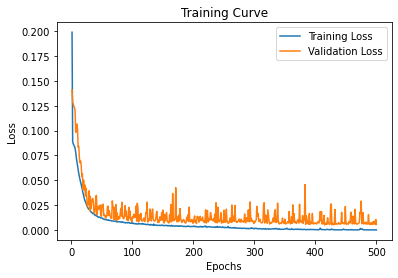

Training Completed.
for user: 2
[[19  0  2  2  0  0  0  0  0  0  2]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 22  0  0  0  0  0  3  0  0]
 [ 2  0  2 21  0  0  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  2  0  0  0 23  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.9454545454545454
Data Setup Started
Data Setup Completed
Building model


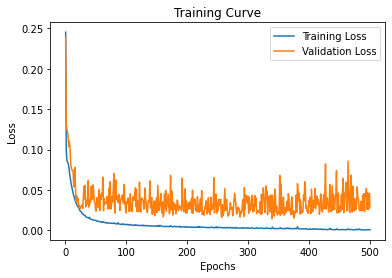

Training Completed.
for user: 3
[[10  0  0 15  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  1  0  0  0]
 [ 0  0 13 10  1  0  0  0  0  0  1]
 [ 0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  1  0 24  0  0  0  0  0  0]
 [ 0  0  0  0  0 22  3  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  1 24  0  0  0]
 [ 0  0  0  0  4  0  0  0 21  0  0]
 [ 0  0  0  0  2  1  0  0  0 22  0]
 [ 1  0  0  1  0  0  0  0  0  0 23]]
0.8472727272727273
Data Setup Started
Data Setup Completed
Building model


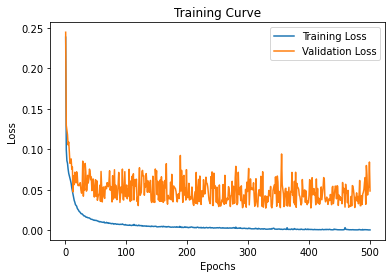

Training Completed.
for user: 5
[[22  0  0  0  0  0  0  0  0  0  3]
 [ 0 24  1  0  0  0  0  0  0  0  0]
 [ 1  0 21  0  0  0  0  0  1  2  0]
 [18  0  0  7  0  0  0  0  0  0  0]
 [ 0  0  1  1 23  0  0  0  0  0  0]
 [ 0  0  0  0  1 18  5  1  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  5  0  0  0 20  0  0]
 [ 0  0  0  0  0  1  0  0  0 24  0]
 [ 0  0  0  1  0  0  0  0  0  0 24]]
0.8472727272727273
Data Setup Started
Data Setup Completed
Building model


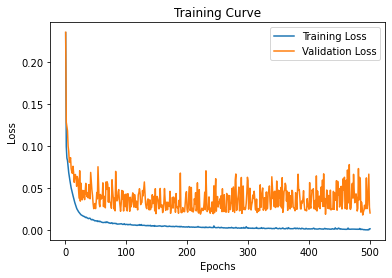

Training Completed.
for user: 6
[[22  0  0  3  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0  2  0]
 [ 0  0 12  0  0  0  0  3  0  0 10]
 [ 7  0  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  0 24  0  0  0  0  1  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  9  0  0  0  0  0  0 15  1  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.8690909090909091
Data Setup Started
Data Setup Completed
Building model


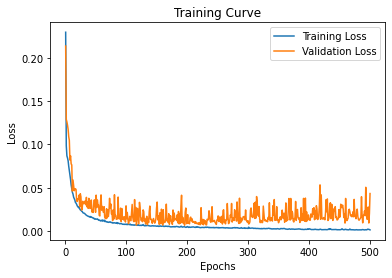

Training Completed.
for user: 8
[[20  0  1  2  0  0  0  0  0  0  2]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  5  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  7  0 18  0  0  0  0  0  0]
 [ 0  0  0  0  0 20  3  0  0  2  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  4  0  0  0  0 21  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.9054545454545454
Data Setup Started
Data Setup Completed
Building model


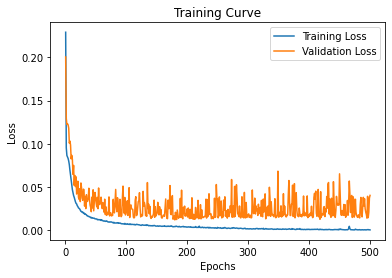

Training Completed.
for user: 9
[[11  0  0 13  0  0  0  0  0  0  1]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 21  0  2  0  0  0  2  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0  0 19  0  0  0  6  0  0]
 [ 0  0  0  0  0 22  2  0  0  1  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  1  0  0  0  0  7 17  0]
 [ 1  0  0  0  0  0  0  0  0  0 24]]
0.8690909090909091
Data Setup Started
Data Setup Completed
Building model


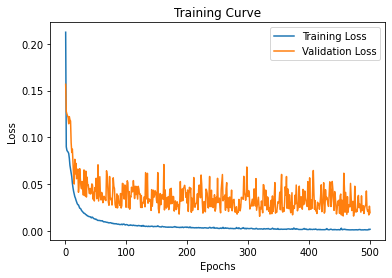

Training Completed.
for user: 10
[[18  0  3  2  0  0  0  0  0  0  2]
 [ 0 24  1  0  0  0  0  0  0  0  0]
 [ 0  0 24  0  0  0  0  0  0  0  1]
 [ 3  0  7 15  0  0  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  1  0  1  0  0  0 23  0  0]
 [ 0  0  0  0  5  8  0  0  0 12  0]
 [ 8  0  0  0  0  0  0  0  0  0 17]]
0.8472727272727273
Data Setup Started
Data Setup Completed
Building model


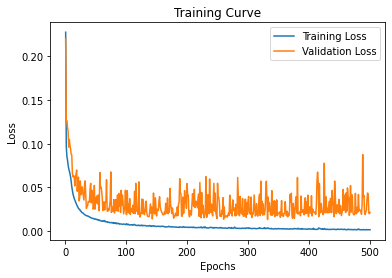

Training Completed.
for user: 11
[[21  0  0  4  0  0  0  0  0  0  0]
 [ 0 20  0  0  2  0  0  0  3  0  0]
 [ 1  0 24  0  0  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0]
 [ 0  0  0  1  3  0  0  0 20  1  0]
 [ 0  0  0  1  0 24  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  1  0  0  0 24  0]
 [ 4  0  0  0  0  0  0  0  0  0 21]]
0.8618181818181818
Data Setup Started
Data Setup Completed
Building model


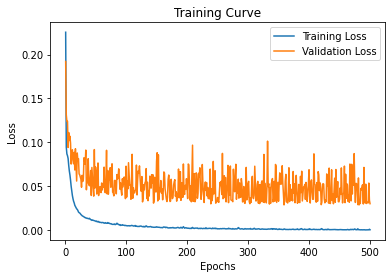

Training Completed.
for user: 12
[[18  0  0  7  0  0  0  0  0  0  0]
 [ 0 23  2  0  0  0  0  0  0  0  0]
 [ 3  0 21  1  0  0  0  0  0  0  0]
 [19  0  2  2  0  0  0  0  0  0  2]
 [ 0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  1  0 24  0  0  0  0  0]
 [ 0  0  0  0  0  3 16  6  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  4  5  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  2  0  0  0  0 23  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.7927272727272727
Data Setup Started
Data Setup Completed
Building model


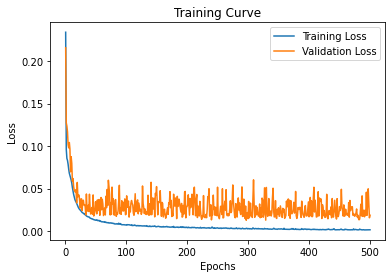

Training Completed.
for user: 13
[[14  0  0  0  0  0  0  0  0  0 11]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 1  0 24  0  0  0  0  0  0  0  0]
 [ 6  0  6 12  0  0  0  0  1  0  0]
 [ 0  9  2  0  9  0  0  0  0  5  0]
 [ 0  0  0  0  0 21  0  1  0  3  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0 25]]
0.8363636363636363


In [50]:
users = [2,3,5,6,8,9,10,11,12,13]
combined_conf=[]
for user in users:
  X_train, y_train = get_data_user(True,40,user)
  X_test_use, y_test_use = get_data_user(False,40,user)
  X_test,X_val,y_test,y_val = get_test_val(X_test_use,y_test_use)
  model1 = net(40,6,False,216,54,True)
  model1 = training(model1,0.0003,500,64,'MSE',0.9,SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val),True,False,SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),False)
  accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
  accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
  
  print("for user: "+ str(user))
  print(conf+conf2)
  print((np.trace(conf+conf2)/np.sum(conf+conf2)))
  combined_conf.append((conf+conf2))

In [51]:
total_conf = None
for i in range(len(combined_conf)):
  if i==0:
    total_conf = combined_conf[i]
  else:
    total_conf += combined_conf[i]

print(total_conf)
print(np.trace(total_conf)/np.sum(total_conf))

[[175   0   6  48   0   0   0   0   0   0  21]
 [  0 238   4   0   2   0   0   1   3   2   0]
 [  6   0 202  11   8   0   0   3   6   2  12]
 [ 55   0  17 175   0   0   0   0   1   0   2]
 [  0   9  11   2 195   0   0   0  26   7   0]
 [  0   0   0   2   1 226  13   2   0   6   0]
 [  0   0   0   0   0   3 241   6   0   0   0]
 [  0   0   0   0   0   0   1 249   0   0   0]
 [  0  13   6   0  10   0   0   0 220   1   0]
 [  0   0   0   1  13  13   0   0   7 216   0]
 [ 14   0   0   2   0   0   0   0   0   0 234]]
0.8621818181818182


#### Inter Session Testing

In [52]:
import pickle
from random import sample
def get_data_session(train,sess,number_of_frames):
  base_n = "/content/drive/MyDrive/session_wise_data/"
  sessions = [0,1,4,7,13,14]

  with open(base_n+'train.pickle', 'rb') as f:
    data_tr = pickle.load(f)
  with open(base_n+'test.pickle', 'rb') as f:
    data_te = pickle.load(f)

  if train:
    sessions.remove(sess)
    
  else:
    sessions = [sess]

  X = []
  y = []
  keys = np.arange(11)
  for key in keys:
    for session in sessions:
      if session != 14 and session != 7 and session != 4:
        data = data_tr
      else:
        data = data_te
        
      gesture_data = data[session][key]
      for i in range(len(gesture_data)):
        datapt_arr = gesture_data[i]
        datapt= (datapt_arr[0]+datapt_arr[1]+datapt_arr[2]+datapt_arr[3])/4
        num_frames = np.shape(datapt)[0]

        if num_frames < number_of_frames:
            size = number_of_frames - num_frames
            use = np.zeros((size,32,32))
            datapt = np.vstack((datapt,use))      ## subsampling and extension so that finally all sequences are of length 40

        if num_frames > number_of_frames:
            datapt = datapt[np.sort(np.random.randint(datapt.shape[0],size=number_of_frames)),:,:]
            

        minimum = datapt.min()
        maximum = datapt.max()                                ## Linear Normalization of pixel values to 0-1
        datapt = (datapt-minimum)/((maximum-minimum))    

        X.append(datapt)
        y_temp = np.zeros(11)
        y_temp[key]=1
        y.append(y_temp)
      
  return X,y

In [53]:
from sklearn.model_selection import train_test_split
def get_test_val(X_test_use,y_test_use):
  X_val =[]
  y_val =[]
  X_test=[]
  y_test=[]
  _,count = np.unique(y_test_use,axis=0,return_counts=True)
  count = count[0]
  for i in range(11):
    val_X,test_X,val_y,test_y = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],test_size=0.50,random_state=2)
    X_val.extend(val_X)
    X_test.extend(test_X)
    y_val.extend(val_y)
    y_test.extend(test_y)
  return X_test,X_val,y_test,y_val

Data Setup Started
Data Setup Completed
Building model


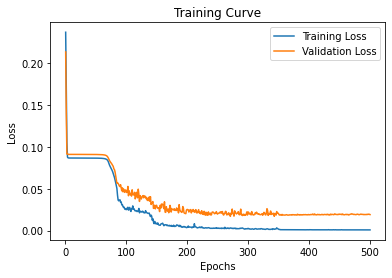

Training Completed.
0.8903318903318903
[[43  0  1  5  0  0  0  0  0  0 14]
 [ 0 63  0  0  0  0  0  0  0  0  0]
 [ 0  0 41 18  1  0  0  0  2  0  1]
 [ 0  0  0 58  0  5  0  0  0  0  0]
 [ 0  0  0  2 60  1  0  0  0  0  0]
 [ 0  0  0  0  0 56  2  5  0  0  0]
 [ 0  0  0  0  0  0 63  0  0  0  0]
 [ 0  0  0  0  1  0  0 60  0  2  0]
 [ 0  0  0  1  1  0  0  0 61  0  0]
 [ 0  0  0  1  2  1  0  0  3 56  0]
 [ 4  0  0  3  0  0  0  0  0  0 56]]


In [ ]:
model1 = net(40,6,False,216,54,True)  ## 1st
model1 = training(model1,0.1,500,64,'MSE',0.9,SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val),True,True,SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),False)
accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print(accu)
print(conf)

In [ ]:
accu1, conf1 = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print(conf1+conf2)
print(np.trace(conf1+conf2)/np.sum(conf1+conf2))

[[ 88   0   1  14   0   0   0   0   0   0  22]
 [  0 125   0   0   0   0   0   0   0   0   0]
 [  0   0  80  39   2   0   0   0   3   0   1]
 [  1   0   0 112   0  11   1   0   0   0   0]
 [  0   0   0   7 117   1   0   0   0   0   0]
 [  0   0   0   1   0 110   4  10   0   0   0]
 [  0   0   0   0   0   0 125   0   0   0   0]
 [  0   0   0   0   2   0   0 120   0   3   0]
 [  0   0   0   1   3   0   0   0 121   0   0]
 [  0   0   0   1   2   1   0   1   4 116   0]
 [ 15   0   0   4   0   0   0   0   0   0 106]]
0.8872727272727273


Data Setup Started
Data Setup Completed
Building model


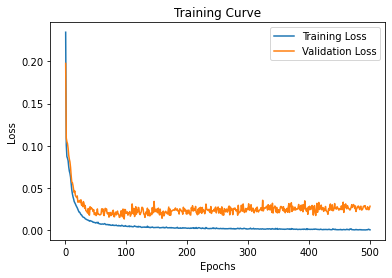

Training Completed.
for session: 0
[[ 7  0  0  0  0  0  0  0  0  0 43]
 [ 0 47  3  0  0  0  0  0  0  0  0]
 [ 1  0 49  0  0  0  0  0  0  0  0]
 [ 7  0  2 40  0  0  1  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  1  0 49  0  0  0  0  0]
 [ 0  0  0  0  0  2 48  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0]
 [ 0  3  9  0  0  0  0  0 38  0  0]
 [ 0  0  0  0  3  0  0  0  0 47  0]
 [ 5  0  0  0  0  0  0  0  0  0 45]]
0.8545454545454545
Data Setup Started
Data Setup Completed
Building model


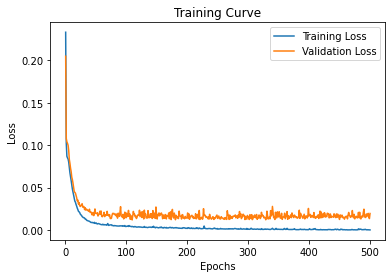

Training Completed.
for session: 1
[[46  0  0  3  0  0  0  0  0  0  1]
 [ 0 50  0  0  0  0  0  0  0  0  0]
 [ 1  0 49  0  0  0  0  0  0  0  0]
 [21  0  0 26  0  0  0  0  0  0  3]
 [ 0  0  0  0 49  0  0  0  1  0  0]
 [ 0  0  0  4  0 46  0  0  0  0  0]
 [ 0  0  0  0  0  1 49  0  0  0  0]
 [ 0  0  0  0  0  1  0 49  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0]
 [ 6  0  0  1  0  0  0  0  0  0 43]]
0.9218181818181819
Data Setup Started
Data Setup Completed
Building model


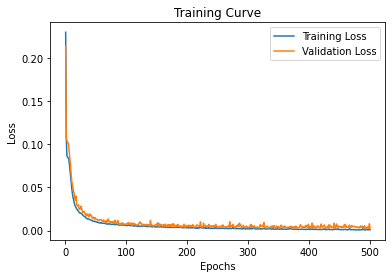

Training Completed.
for session: 4
[[48  0  0  1  0  0  0  0  0  0  1]
 [ 0 50  0  0  0  0  0  0  0  0  0]
 [ 1  0 47  0  0  0  0  0  2  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0  0 49  0  0  0  0  1  0]
 [ 0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  1  0  0  0 46  3  0]
 [ 0  0  0  0  1  0  0  0  1 48  0]
 [ 1  0  0  0  0  0  0  0  0  0 49]]
0.9763636363636363
Data Setup Started
Data Setup Completed
Building model


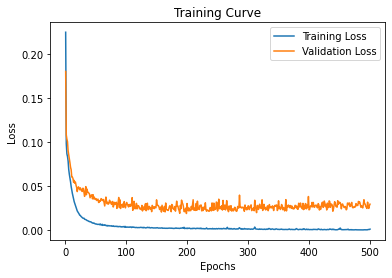

Training Completed.
for session: 7
[[31  0  4 12  0  0  0  0  0  0  3]
 [ 0 50  0  0  0  0  0  0  0  0  0]
 [ 1  0 35 13  0  0  0  0  1  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0]
 [ 0  0 21  1 18  0  0  0  4  6  0]
 [ 0  0  0  0  0 49  1  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  2  0  0 48  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  1 49  0]
 [28  0  0  2  0  0  0  0  0  0 20]]
0.8181818181818182
Data Setup Started
Data Setup Completed
Building model


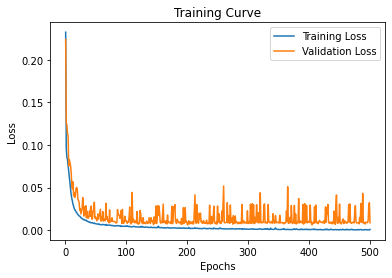

Training Completed.
for session: 13
[[17  0  0  4  0  0  0  0  0  0  4]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0]
 [ 0  0  6 18  1  0  0  0  0  0  0]
 [ 0  1  0  0 24  0  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 1  0  0  0  0  0  0  0  0  0 24]]
0.9381818181818182
Data Setup Started
Data Setup Completed
Building model


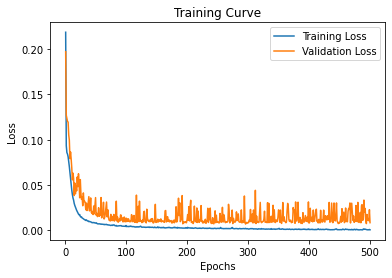

Training Completed.
for session: 14
[[23  0  0  0  0  0  0  0  0  0  2]
 [ 0 25  0  0  0  0  0  0  0  0  0]
 [ 0  0 21  0  4  0  0  0  0  0  0]
 [ 0  0  1 23  0  0  0  0  0  1  0]
 [ 0  0  0  0 24  0  0  0  1  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 4  0  0  0  0  0  0  0  0  0 21]]
0.9527272727272728


In [ ]:
sessions = [0,1,4,7,13,14]
conf_list = []
for session in sessions:
  X_train, y_train = get_data_session(True,session,40)
  X_test_use, y_test_use = get_data_session(False,session,40)
  X_test,X_val,y_test,y_val = get_test_val(X_test_use,y_test_use)
  model1 = net(40,6,False,216,54,True)  ## 1st
  model1 = training(model1,0.0003,500,64,'MSE',0.9,SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val),True,False,SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),False)
  accu1, conf1 = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
  accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
  print("for session: " + str(session))
  print(conf1+conf2)
  print(np.trace(conf1+conf2)/np.sum(conf1+conf2))
  conf_list.append((conf1+conf2))

In [ ]:
total_conf = None
for i in range(len(conf_list)):
  if i==0:
    total_conf = conf_list[i]
  else:
    total_conf += conf_list[i]

print(total_conf)
print(np.trace(total_conf)/np.sum(total_conf))

[[172   0   4  20   0   0   0   0   0   0  54]
 [  0 247   3   0   0   0   0   0   0   0   0]
 [  4   0 226  13   4   0   0   0   3   0   0]
 [ 28   0   9 207   1   0   1   0   0   1   3]
 [  0   1  21   1 214   0   0   0   6   7   0]
 [  0   0   0   5   0 244   1   0   0   0   0]
 [  0   0   0   0   0   3 247   0   0   0   0]
 [  0   0   0   0   2   1   0 247   0   0   0]
 [  0   3   9   0   1   0   0   0 234   3   0]
 [  0   0   0   0   4   0   0   0   2 244   0]
 [ 45   0   0   3   0   0   0   0   0   0 202]]
0.9032727272727272


## Pruned Data Set model

In [23]:
class pnet(nn.Module):
  """
  This is the overall class implementing the CNN architecture
  """

  def __init__(self,inp_channels,num_filters,bw,neurons_2nd_last_lyr,neurons_last_lyr,relu,num_classes):
    """
    inp_channels: Number of channels in your image for eg RGB has 3, Black and White has 1
    Num_Filters: How many filters should be used in the first convolutional layer
    bw: is the image black and white? [Boolean]
    """

    super(pnet, self).__init__()
    self.inp_channels = inp_channels
    self.num_filters=num_filters
    self.bw = bw
    self.neurons1 = neurons_2nd_last_lyr
    self.neurons2 = neurons_last_lyr
    self.relu = relu
    self.classes = num_classes

    self.conv1 = nn.Conv2d(self.inp_channels,num_filters,5,stride=1,padding=2)   # Adjust the Filter size and padding accordingly
    self.pool1 = nn.MaxPool2d(2,stride=2) ## image dimensions halved
    self.conv2 = nn.Conv2d(self.num_filters,self.num_filters*2,5,stride=1,padding=0)
    self.pool2 = nn.MaxPool2d(2,stride=2) ## image dimensions halved
    ## Non Linearities are added using nn.Functional

    self.fc1 = nn.Linear(432,self.neurons1)   ## base this on input image dimension
    self.fc2 = nn.Linear(self.neurons1,self.neurons2)
    self.fc3 = nn.Linear(self.neurons2,self.classes)
    

  def forward(self,X):
    """
    Forward Loop of CNN.
    X is the input with dimension as: batch_size x input_channels x height x width
    """
    if self.bw:
      X = torch.unsqueeze(X,1)   ## in case your input image is 2D use this line to convert your 2D image into 3 Dimensional form [1 x height x width]
    
    if self.relu:
      X = F.relu(self.conv1(X))   # B_sizex6x32x32
      X = self.pool1(X)  ## B_sizex6x16x16
      X = F.relu(self.conv2(X))  ## B_sizex12x12x12
      X = self.pool2(X) ## B_sizex12x6x6

      X = X.view(-1,432)  ## B_sizex432
      X = F.relu(self.fc1(X))
      X = F.relu(self.fc2(X))
      X = torch.sigmoid(self.fc3(X))
    
    else:
      X = torch.sigmoid(self.conv1(X))   # 6x32x32
      X = self.pool1(X)  ## 6x16x16
      X = torch.sigmoid(self.conv2(X))  ## 12x12x12
      X = self.pool2(X) ## 12x6x6

      X = X.view(-1,432)  # Flatten the input before inputting into FC layers  432
      X = torch.sigmoid(self.fc1(X))
      X = torch.sigmoid(self.fc2(X))
      X = torch.sigmoid(self.fc3(X))


    return X 

## Pruned Data Set with removal of gestures [0,3]

##### Baseline


In [54]:
import pickle
from random import sample
def get_pruned_data(train,number_of_frames,remove_gestures):
  
  if train:
    with open(base+'train.pickle', 'rb') as f:
        data = pickle.load(f)
  else:
    with open(base+'test.pickle', 'rb') as f:
      data = pickle.load(f)

  X = []
  y = []
  keys = np.zeros(11-len(remove_gestures),dtype=int)
  j=0
  for i in range(11):
    if i not in remove_gestures:
      keys[j]=i
      j= j+1

  keys = list(keys)
  for key in keys:
    gesture_data = data[key]
    for i in range(len(gesture_data)):
      datapt_arr = gesture_data[i]
      datapt= (datapt_arr[0]+datapt_arr[1]+datapt_arr[2]+datapt_arr[3])/4
      num_frames = np.shape(datapt)[0]

      if num_frames < number_of_frames:
          size = number_of_frames - num_frames
          use = np.zeros((size,32,32))
          datapt = np.vstack((datapt,use))      ## subsampling and extension so that finally all sequences are of length 40

      if num_frames > number_of_frames:
          datapt = datapt[np.sort(np.random.randint(datapt.shape[0],size=number_of_frames)),:,:]
          

      minimum = datapt.min()
      maximum = datapt.max()                                ## Linear Normalization of pixel values to 0-1
      datapt = (datapt-minimum)/((maximum-minimum))  

      X.append(datapt)
      y_temp = np.zeros(11-len(remove_gestures))
      y_temp[keys.index(key)]=1
      y.append(y_temp)
  return X,y

In [55]:
def get_test_val(X_test_use,y_test_use,remove):
  from sklearn.model_selection import train_test_split
  X_val =[]
  y_val =[]
  X_test=[]
  y_test=[]
  count = 124
  for i in range(11-len(remove)):
    val_X,test_X,val_y,test_y = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],test_size=0.50,random_state=2)
    X_val.extend(val_X)
    X_test.extend(test_X)
    y_val.extend(val_y)
    y_test.extend(test_y)
  return X_test,X_val,y_test,y_val

In [ ]:
X_train, y_train = get_pruned_data(True,40,[0,2])
X_test_use, y_test_use = get_pruned_data(False,40,[0,2])

In [ ]:
X_test,X_val,y_test,y_val = get_test_val(X_test_use,y_test_use,[0,2])

In [14]:
from torchsummary import summary
model = pnet(40,6,False,216,54,True,9)
model.to(device)
summary(model,input_size=(40,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]           6,006
         MaxPool2d-2            [-1, 6, 16, 16]               0
            Conv2d-3           [-1, 12, 12, 12]           1,812
         MaxPool2d-4             [-1, 12, 6, 6]               0
            Linear-5                  [-1, 216]          93,528
            Linear-6                   [-1, 54]          11,718
            Linear-7                    [-1, 9]             495
Total params: 113,559
Trainable params: 113,559
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.16
Forward/backward pass size (MB): 0.08
Params size (MB): 0.43
Estimated Total Size (MB): 0.67
----------------------------------------------------------------


Data Setup Started
Data Setup Completed
Building model


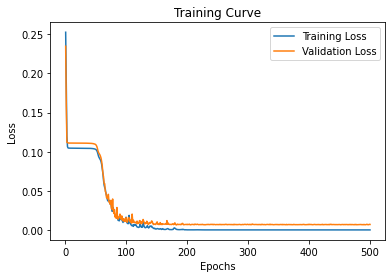

Training Completed.
0.9731182795698925
[[59  0  1  0  0  0  0  1  1]
 [ 0 60  1  0  0  0  0  0  1]
 [ 0  1 60  0  0  0  1  0  0]
 [ 0  0  0 60  1  1  0  0  0]
 [ 0  0  0  2 60  0  0  0  0]
 [ 0  0  0  0  0 62  0  0  0]
 [ 0  0  0  0  0  0 62  0  0]
 [ 0  0  1  1  0  0  0 60  0]
 [ 0  2  0  0  0  0  0  0 60]]


In [ ]:
model1 = pnet(40,6,False,216,54,True,9)  ## 1st
model1 = training(model1,0.1,500,64,'MSE',0.9,SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val),True,True,SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),False)
accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print(accu)
print(conf)

In [ ]:
accu1, conf1 = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print(np.trace(conf1+conf2)/np.sum(conf1+conf2))
print(conf1+conf2)

0.9686379928315412
[[120   0   1   0   0   0   0   2   1]
 [  0 121   1   0   0   0   0   0   2]
 [  0   2 119   0   0   0   3   0   0]
 [  0   0   0 116   4   1   0   3   0]
 [  0   0   0   4 120   0   0   0   0]
 [  0   0   0   0   0 124   0   0   0]
 [  0   0   5   0   0   0 119   0   0]
 [  0   0   1   2   0   0   0 121   0]
 [  0   3   0   0   0   0   0   0 121]]


##### New User Testing

In [56]:
import pickle
from random import sample
def get_pruning_data_user(train,number_of_frames,user_number,remove_gestures):
  base_n = "/content/drive/MyDrive/data_soli_userwise_dictionaries/"
  users = [2,3,5,6,8,9,10,11,12,13]
  
  with open(base_n+'train.pickle', 'rb') as f:
    data_tr = pickle.load(f)
  with open(base_n+'test.pickle', 'rb') as f:
    data_te = pickle.load(f)

  X = []
  y = []
 
  
  keys = np.zeros(11-len(remove_gestures),dtype=int)
  j=0
  for i in range(11):
    if i not in remove_gestures:
      keys[j]=i
      j= j+1

  keys = list(keys)

  for data in [data_tr,data_te]:
    for key in keys:
      for user in users:
        gesture_data = data[user][key]
        
        for i in range(len(gesture_data)):
          datapt_arr = gesture_data[i]
          datapt= (datapt_arr[0]+datapt_arr[1]+datapt_arr[2]+datapt_arr[3])/4
          num_frames = np.shape(datapt)[0]

          if num_frames < number_of_frames:
              size = number_of_frames - num_frames
              use = np.zeros((size,32,32))
              datapt = np.vstack((datapt,use))      ## subsampling and extension so that finally all sequences are of length 40

          if num_frames > number_of_frames:
              datapt = datapt[np.sort(np.random.randint(datapt.shape[0],size=number_of_frames)),:,:]
              

          minimum = datapt.min()
          maximum = datapt.max()                                ## Linear Normalization of pixel values to 0-1
          datapt = (datapt-minimum)/((maximum-minimum))    

          if user != user_number:
            if train:
              X.append(datapt)
              y_temp = np.zeros(11-len(remove_gestures))
              y_temp[keys.index(key)]=1
              y.append(y_temp)
          else:
            if not train:
              X.append(datapt)
              y_temp = np.zeros(11-len(remove_gestures))
              y_temp[keys.index(key)]=1
              y.append(y_temp)
        
      
  return X,y

In [57]:
from sklearn.model_selection import train_test_split
def get_test_eval(X_test_use,y_test_use,remove):
  X_val =[]
  y_val =[]
  X_test=[]
  y_test=[]
  _,counts= np.unique(y_test_use,axis=0,return_counts=True)
  counts = np.flipud(counts)
  for i in range(11-len(remove)):
    count = counts[i]
    val_X,test_X,val_y,test_y = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],test_size=0.50,random_state=2)
    X_val.extend(val_X)
    X_test.extend(test_X)
    y_val.extend(val_y)
    y_test.extend(test_y)
  return X_test,X_val,y_test,y_val

In [18]:
X_train, y_train = get_pruning_data_user(True,40,13,[0,2])
X_test_use, y_test_use = get_pruning_data_user(False,40,13,[0,2])

In [19]:
X_test,X_val,y_test,y_val = get_test_eval(X_test_use,y_test_use,[0,2])

Data Setup Started
Data Setup Completed
Building model


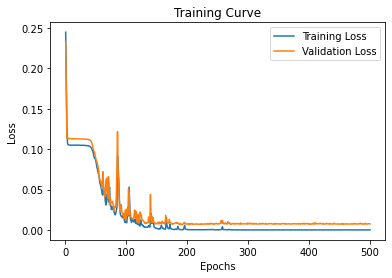

Training Completed.
0.973305954825462
[[57  0  0  0  0  0  1  0  0]
 [ 0 59  0  0  0  0  0  0  2]
 [ 0  0 49  0  0  0  0  0  0]
 [ 0  0  0 69  0  0  0  1  0]
 [ 0  0  0  1 39  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0]
 [ 1  0  2  0  0  0 53  0  0]
 [ 0  0  3  2  0  0  0 46  0]
 [ 0  0  0  0  0  0  0  0 43]]


In [ ]:
model1 = pnet(40,6,False,216,54,True,9)  ## 1st
model1 = training(model1,0.1,500,64,'MSE',0.9,SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val),True,True,SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),False)
accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print(accu)
print(conf)

In [ ]:
accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
accu3, conf3 = testing_conf(TestNewUserData(True,X_train_user,y_train_user,X_test_use_user,y_test_use_user),model1,device,'MSE')
accu4, conf4 = testing_conf(TestNewUserData(False,X_train_user,y_train_user,X_test_use_user,y_test_use_user),model1,device,'MSE')

In [ ]:
print(conf+conf2)
print((np.trace(conf+conf2)/np.sum(conf+conf2)))

[[109   0   2   0   0   0   1   2   0]
 [  0 113   0   0   0   0   0   0   5]
 [  0   0 102   0   0   0   0   0   0]
 [  0   0   0 128   0   1   0   2   0]
 [  0   0   0   1  87   0   0   0   0]
 [  0   0   0   0   0 113   0   0   0]
 [  4   1   4   0   0   0 103   0   0]
 [  0   0   5   3   0   0   0  98   0]
 [  0   0   0   0   0   0   0   0  86]]
0.9680412371134021


In [ ]:
print(conf3+conf4)
print((np.trace(conf3+conf4)/np.sum(conf3+conf4)))

[[25  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  1]
 [ 2  0 17  0  0  0  1  5  0]
 [ 0  0  0 22  0  0  0  3  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0 25]]
0.9466666666666667


In [ ]:
print(conf+conf2+conf3+conf4)
print((np.trace(conf+conf2+conf3+conf4)/np.sum(conf+conf2+conf3+conf4)))

[[134   0   2   0   0   0   1   2   0]
 [  0 137   0   0   0   0   0   0   6]
 [  2   0 119   0   0   0   1   5   0]
 [  0   0   0 150   0   1   0   5   0]
 [  0   0   0   1 112   0   0   0   0]
 [  0   0   0   0   0 138   0   0   0]
 [  4   1   4   0   0   0 128   0   0]
 [  0   0   5   3   0   0   0 123   0]
 [  0   0   0   0   0   0   0   0 111]]
0.9640167364016736


Data Setup Started
Data Setup Completed
Building model


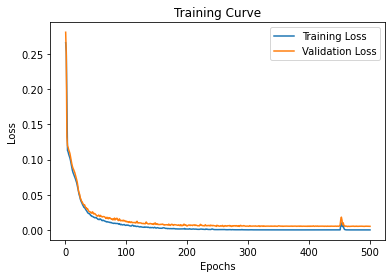

Training Completed.
for user: 2
[[25  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0]
 [ 0  0  0 23  1  0  0  1  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  1  0  0  2 22  0]
 [ 0  0  0  0  0  0  0  0 25]]
0.9777777777777777
[[151   0   0   0   0   0   1   0   0]
 [  0 123   1   0   0   0   0   0   2]
 [  0   0 129   0   0   0   1   1   0]
 [  0   0   0 142   3   0   0   3   0]
 [  0   0   0   0 118   5   0   0   0]
 [  0   0   0   0   0 128   0   0   0]
 [  0   0   4   0   0   0 138   1   0]
 [  0   0   0   3   0   0   2 136   0]
 [  0   2   0   0   0   0   0   0 134]]
0.9763843648208469
Data Setup Started
Data Setup Completed
Building model


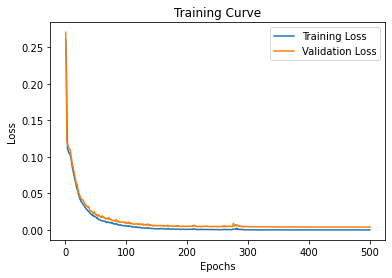

Training Completed.
for user: 3
[[25  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0]
 [ 0  0 24  0  0  0  0  1  0]
 [ 0  0  0 20  5  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  2  0  0  0 22  1  0]
 [ 0  0  1  2  0  0  0 22  0]
 [ 0  2  0  0  0  0  0  0 23]]
0.9377777777777778
[[139   0   0   0   0   0   0   0   0]
 [  0 137   1   0   0   0   0   0   1]
 [  0   0 141   0   0   0   0   4   0]
 [  0   0   0 125   5   0   0   2   0]
 [  0   0   0   2 150   0   0   0   0]
 [  0   0   0   0   0 131   0   0   0]
 [  0   0   2   0   0   0 126   1   0]
 [  0   0   1   3   0   0   5 166   0]
 [  0   3   0   0   0   0   0   0  94]]
0.9757869249394673
Data Setup Started
Data Setup Completed
Building model


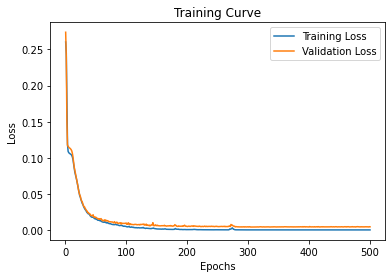

Training Completed.
for user: 5
[[24  0  0  0  0  0  0  0  1]
 [ 0 25  0  0  0  0  0  0  0]
 [ 0  9 16  0  0  0  0  0  0]
 [ 0  2  0 20  3  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  1  5  0  0  0 19  0  0]
 [ 0  0  0  1  0  0  0 24  0]
 [ 0  4  0  0  0  0  0  0 21]]
0.8844444444444445
[[133   0   1   0   0   0   0   0   2]
 [  0 135   0   0   0   0   0   0   1]
 [  0  10 130   0   0   0   0   2   0]
 [  0   3   2 128   3   1   0   1   0]
 [  0   0   0   2 138   0   0   1   0]
 [  0   0   0   0   0 141   0   0   0]
 [  1   1   5   0   0   0 111   1   0]
 [  0   0   1   2   0   0   0 125   0]
 [  0   5   0   0   0   0   0   0 141]]
0.9633251833740831
Data Setup Started
Data Setup Completed
Building model


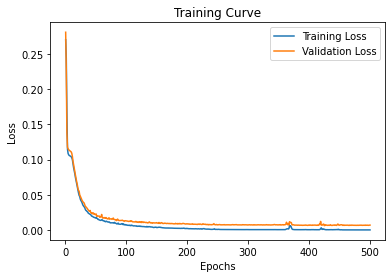

Training Completed.
for user: 6
[[22  0  0  0  0  0  0  3  0]
 [ 0 25  0  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  2  0]
 [ 0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [12  0  4  0  0  0  4  5  0]
 [ 0  0  1  1  0  0  1 22  0]
 [ 0  0  0  0  0  0  0  0 25]]
0.8711111111111111
[[131   0   0   0   0   0   0   3   0]
 [  0 131   1   2   0   0   0   0   0]
 [  0   1 132   0   0   0   0   5   0]
 [  0   0   0 135   1   0   0   0   0]
 [  0   0   0   0 127   0   0   0   0]
 [  0   0   0   2   0 141   0   0   0]
 [ 15   1   7   0   0   0 136   6   0]
 [  0   0   3   1   0   0   1 112   0]
 [  0   3   0   0   0   0   0   0 130]]
0.9576202118989405
Data Setup Started
Data Setup Completed
Building model


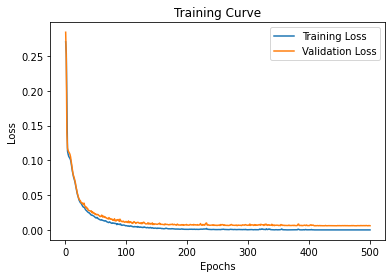

Training Completed.
for user: 8
[[25  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0]
 [ 0  0  0 15  7  1  0  2  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  1  0  0  0 24  0  0]
 [ 0  0 10  0  0  0  0 15  0]
 [ 0  0  0  0  0  0  0  0 25]]
0.9066666666666666
[[134   0   0   0   0   0   0   1   0]
 [  0 131   0   0   0   0   1   0   0]
 [  0   0 128   1   0   0   0   2   0]
 [  0   0   0 124   7   1   0   2   0]
 [  0   0   0   0 130   0   0   1   0]
 [  0   0   0   0   0 151   0   0   0]
 [  3   0   5   0   0   0 122   1   0]
 [  0   0  11   3   0   0   1 118   0]
 [  0   4   0   0   0   0   0   0 144]]
0.964110929853181
Data Setup Started
Data Setup Completed
Building model


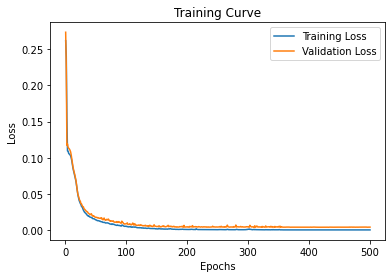

Training Completed.
for user: 9
[[22  0  0  0  0  0  3  0  0]
 [ 0 25  0  0  0  0  0  0  0]
 [ 0  1 24  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  1  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  1  0  0  0  0 24  0]
 [ 0  0  0  0  0  0  0  0 25]]
0.9733333333333334
[[129   0   1   0   0   0   3   1   1]
 [  0 134   0   0   0   0   1   0   0]
 [  0   1 130   0   0   0   0   1   0]
 [  0   0   0 145   0   0   0   2   0]
 [  0   0   0   2 123   0   0   0   0]
 [  0   0   0   0   0 182   0   0   0]
 [  0   0   0   0   0   0 108   0   0]
 [  0   0   2   3   0   1   1 129   0]
 [  0   3   0   0   0   0   0   0 135]]
0.981421647819063
Data Setup Started
Data Setup Completed
Building model


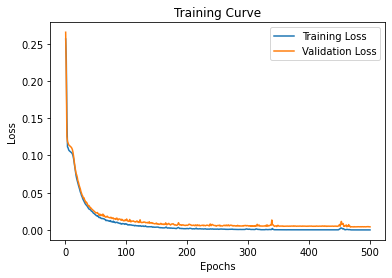

Training Completed.
for user: 10
[[24  0  0  0  0  0  0  0  1]
 [ 0 25  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0 24  1  0  0  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  1 12  0  0  0 12  0  0]
 [ 0  0  1  1  2  0  0 21  0]
 [ 0  4  0  0  0  0  0  0 21]]
0.7911111111111111
[[131   0   1   0   0   0   1   2   1]
 [  0 139   2   0   0   0   0   0   0]
 [  0   0 137   0   0   0   0   1   0]
 [  0   1   0 107  24   1   0   2   0]
 [  0   0   0   1 132   2   0   0   0]
 [  0   0   0   0   0 147   0   0   0]
 [  0   1  14   0   0   0 117   0   0]
 [  0   0   2   1   2   0   2 129   0]
 [  0   6   0   0   0   0   0   0 125]]
0.9455727051177905
Data Setup Started
Data Setup Completed
Building model


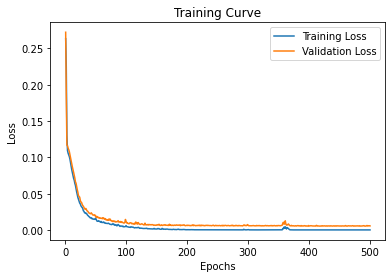

Training Completed.
for user: 11
[[17  0  0  0  0  0  7  1  0]
 [ 0 24  1  0  0  0  0  0  0]
 [ 0  2  0  0  0  0 23  0  0]
 [ 0  0  0 22  0  0  0  3  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  2  0  0  0 23  0]
 [ 0  0  0  0  0  0  0  0 25]]
0.8266666666666667
[[130   0   1   0   0   0   7   2   1]
 [  0 130   1   0   1   0   0   0   1]
 [  0   3 118   0   0   0  23   4   0]
 [  0   0   0 132   0   0   0   4   0]
 [  0   0   0   2 110   2   0   0   0]
 [  0   0   0   0   0 120   0   0   0]
 [  0   0   0   0   0   0 147   2   0]
 [  0   0   0   6   0   0   2 132   0]
 [  0   3   0   0   0   0   0   0 126]]
0.9462809917355371
Data Setup Started
Data Setup Completed
Building model


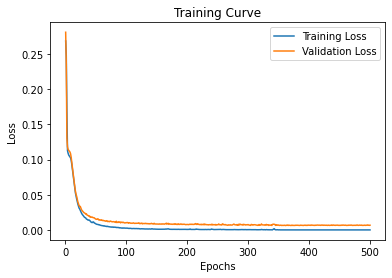

Training Completed.
for user: 12
[[24  0  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  1  0 23]
 [ 0  0 25  0  0  0  0  0  0]
 [ 0  0  1 17  0  0  0  7  0]
 [ 0  0  0 12  9  4  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 2  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0 25]]
0.7733333333333333
[[132   0   1   0   0   0   0   1   0]
 [  0 112   0   0   0   0   1   0  25]
 [  0   3 129   1   0   0   0   1   0]
 [  0   1   1 124   1   0   0  11   0]
 [  0   0   0  12 121   4   0   0   0]
 [  0   0   0   0   0 132   0   0   0]
 [  3   0   1   0   0   0 113   0   0]
 [  0   0   2   0   0   0   3 154   0]
 [  0   3   0   0   0   0   0   0 127]]
0.9384741591468416
Data Setup Started
Data Setup Completed
Building model


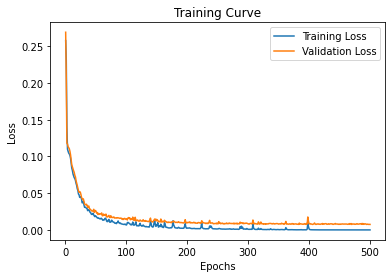

Training Completed.
for user: 13
[[25  0  0  0  0  0  0  0  0]
 [ 0 20  3  0  0  0  2  0  0]
 [ 3  0 13  0  0  0  1  8  0]
 [ 0  0  0 22  0  1  0  2  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0 25]]
0.9111111111111111
[[135   0   0   0   0   0   2   2   0]
 [  0 135   3   0   0   0   4   0   1]
 [  3   0 112   1   0   0   1  10   0]
 [  0   0   0 150   0   1   0   5   0]
 [  0   0   0   0 113   0   0   0   0]
 [  0   0   0   0   0 138   0   0   0]
 [  1   0   2   0   0   0 133   1   0]
 [  0   0   1   3   0   0   1 126   0]
 [  0   1   0   0   0   0   0   0 110]]
0.9640167364016736


In [ ]:
users = [2,3,5,6,8,9,10,11,12,13]
combined_conf=[]

for user in users:
  X_train, y_train = get_pruning_data_user(True,40,user,[0,3])
  X_test_use, y_test_use = get_pruning_data_user(False,40,user,[0,3])
  X_test,X_val,y_test,y_val = get_test_eval(X_test_use,y_test_use,[0,3])
  model1 = pnet(40,6,False,216,54,True,9)
  model1 = training(model1,0.0003,500,64,'MSE',0.9,SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val),True,False,SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),False)
  accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
  accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
  
  print("for user: "+ str(user))
  print(conf+conf2)
  print((np.trace(conf+conf2)/np.sum(conf+conf2)))
  combined_conf.append((conf+conf2))

In [ ]:
total_conf = None
for i in range(len(combined_conf)):
  if i==0:
    total_conf = combined_conf[i]
  else:
    total_conf += combined_conf[i]

print(total_conf)
print(np.trace(total_conf)/np.sum(total_conf))

[[233   0   1   0   0   0  10   4   2]
 [  0 220   4   0   0   0   3   0  23]
 [  3  12 200   0   0   0  24  11   0]
 [  0   2   1 188  40   3   0  16   0]
 [  0   0   0  12 234   4   0   0   0]
 [  0   0   0   0   0 250   0   0   0]
 [ 14   2  24   0   0   0 204   6   0]
 [  0   0  14   8   2   0   3 223   0]
 [  0  10   0   0   0   0   0   0 240]]
0.8853333333333333


### Remove 2 gestures Gestures 3 and 10

Data Setup Started
Data Setup Completed
Building model


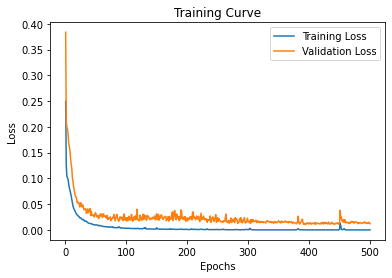

Training Completed.
for user: 2
[[25  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0]
 [ 0  0 21  1  0  0  0  3  0]
 [ 0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0 25]]
0.9822222222222222
Data Setup Started
Data Setup Completed
Building model


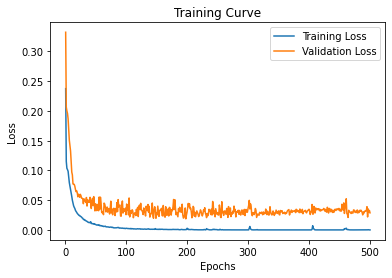

Training Completed.
for user: 3
[[25  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0]
 [ 8  0 17  0  0  0  0  0  0]
 [ 0  0  2 23  0  0  0  0  0]
 [ 0  0  0  0 23  2  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  1  0  0  0 24  0]
 [ 0  0  0  0  1  0  0  0 24]]
0.9377777777777778
Data Setup Started
Data Setup Completed
Building model


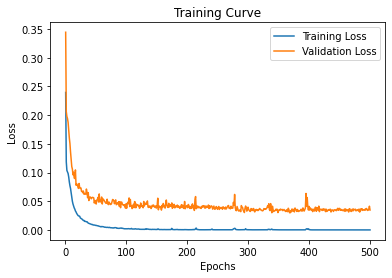

Training Completed.
for user: 5
[[25  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0]
 [ 2  0 21  1  1  0  0  0  0]
 [ 0  0  4 19  0  0  0  0  2]
 [ 0  0  0  3 21  1  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  4  0  0  0 21  0]
 [ 0  2  0  1  0  0  0  0 22]]
0.9066666666666666
Data Setup Started
Data Setup Completed
Building model


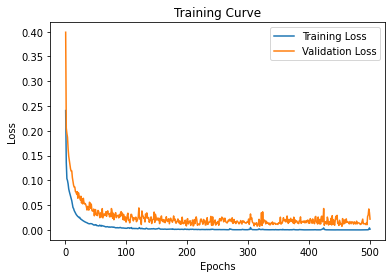

Training Completed.
for user: 6
[[23  0  2  0  0  0  0  0  0]
 [ 0 22  0  0  0  0  0  0  3]
 [ 1  0 24  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  2]
 [ 0  0  0  0 24  1  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  8  1  0  0  0  0 15  1]
 [ 0  0  0  0  0  0  0  0 25]]
0.9155555555555556
Data Setup Started
Data Setup Completed
Building model


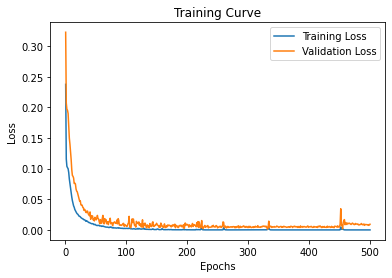

Training Completed.
for user: 8
[[24  0  1  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 25  0]
 [ 0  0  0  2  0  0  0  0 23]]
0.9866666666666667
Data Setup Started
Data Setup Completed
Building model


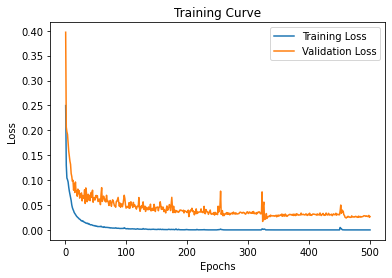

Training Completed.
for user: 9
[[23  0  2  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  1  0]
 [ 0  1 22  1  0  0  0  0  1]
 [ 0  0  1 24  0  0  0  0  0]
 [ 0  0  0  0 22  1  0  0  2]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 24  1]
 [ 0  0  1  0  0  0  0  3 21]]
0.9333333333333333
Data Setup Started
Data Setup Completed
Building model


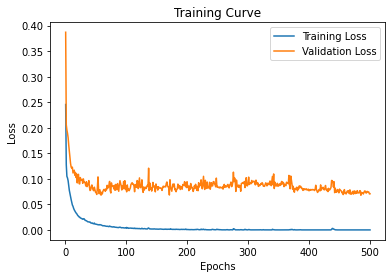

Training Completed.
for user: 10
[[25  0  0  0  0  0  0  0  0]
 [ 0 22  3  0  0  0  0  0  0]
 [ 0  1 24  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0 11 14  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  2  2  0  0  0 20  1]
 [ 0  0  0  9 12  0  0  0  4]]
0.8044444444444444
Data Setup Started
Data Setup Completed
Building model


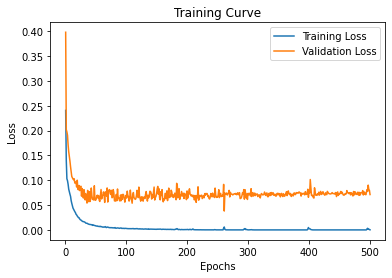

Training Completed.
for user: 11
[[25  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  1  0]
 [ 3  0 22  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0 17  1]
 [ 0  0  0  0 23  0  0  0  2]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  1  0 24  0  0]
 [ 0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  3  0  0  0 22]]
0.8755555555555555
Data Setup Started
Data Setup Completed
Building model


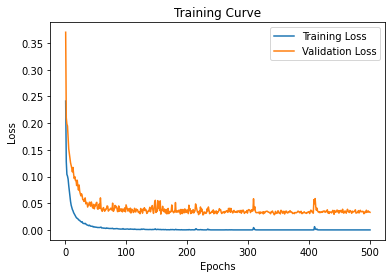

Training Completed.
for user: 12
[[25  0  0  0  0  0  0  0  0]
 [ 0 23  2  0  0  0  0  0  0]
 [ 1  0 24  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0 24  0  0  0  1]
 [ 0  0  0  0  4 11 10  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  4  4  0  0  0  0 17  0]
 [ 0  0  0  0  0  0  0  0 25]]
0.8844444444444445
Data Setup Started
Data Setup Completed
Building model


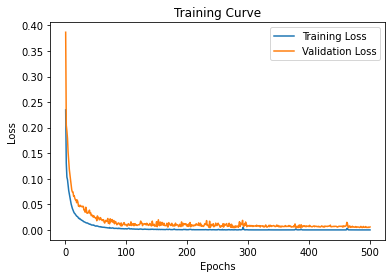

Training Completed.
for user: 13
[[23  0  2  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0]
 [ 0  3  0 22  0  0  0  0  0]
 [ 0  0  0  0 23  0  0  0  2]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0 25]]
0.9688888888888889


In [58]:
users = [2,3,5,6,8,9,10,11,12,13]
combined_conf=[]
remov_gest=[3,10]
for user in users:
  X_train, y_train = get_pruning_data_user(True,40,user,remov_gest)
  X_test_use, y_test_use = get_pruning_data_user(False,40,user,remov_gest)
  X_test,X_val,y_test,y_val = get_test_eval(X_test_use,y_test_use,remov_gest)
  model1 = pnet(40,6,False,216,54,True,9)
  model1 = training(model1,0.0003,500,64,'MSE',0.9,SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val),True,False,SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),False)
  accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
  accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
  
  print("for user: "+ str(user))
  print(conf+conf2)
  print((np.trace(conf+conf2)/np.sum(conf+conf2)))
  combined_conf.append((conf+conf2))

In [59]:
total_conf = None
for i in range(len(combined_conf)):
  if i==0:
    total_conf = combined_conf[i]
  else:
    total_conf += combined_conf[i]

print(total_conf)
print(np.trace(total_conf)/np.sum(total_conf))

[[243   0   7   0   0   0   0   0   0]
 [  0 240   5   0   0   0   0   2   3]
 [ 15   2 225   3   1   0   0   3   1]
 [  0   3   7 218   0   0   0  17   5]
 [  0   0   0   3 221  19   0   0   7]
 [  0   0   0   0   4 236  10   0   0]
 [  0   0   0   0   1   0 249   0   0]
 [  0  12   7   7   0   0   0 221   3]
 [  0   2   1  12  16   0   0   3 216]]
0.9195555555555556


##### Inter session testing


In [61]:
import pickle
from random import sample
def get_prune_data_session(train,number_of_frames,remove_gestures,sess):
  base_n = "/content/drive/MyDrive/session_wise_data/"
  sessions = [0,1,4,7,13,14]

  with open(base_n+'train.pickle', 'rb') as f:
    data_tr = pickle.load(f)
  with open(base_n+'test.pickle', 'rb') as f:
    data_te = pickle.load(f)

  if train:
    sessions.remove(sess)
    
  else:
    sessions = [sess]

  X = []
  y = []
  
  
  keys = np.zeros(11-len(remove_gestures),dtype=int)
  j=0
  for i in range(11):
    if i not in remove_gestures:
      keys[j]=i
      j= j+1

  keys = list(keys)

  for key in keys:
    for session in sessions:

      if session != 14 and session != 7 and session != 4:
        data = data_tr
      else:
        data = data_te
      gesture_data = data[session][key]
      
      for i in range(len(gesture_data)):
        datapt_arr = gesture_data[i]
        datapt= (datapt_arr[0]+datapt_arr[1]+datapt_arr[2]+datapt_arr[3])/4
        num_frames = np.shape(datapt)[0]

        if num_frames < number_of_frames:
            size = number_of_frames - num_frames
            use = np.zeros((size,32,32))
            datapt = np.vstack((datapt,use))      ## subsampling and extension so that finally all sequences are of length 40

        if num_frames > number_of_frames:
            datapt = datapt[np.sort(np.random.randint(datapt.shape[0],size=number_of_frames)),:,:]
            

        minimum = datapt.min()
        maximum = datapt.max()                                ## Linear Normalization of pixel values to 0-1
        datapt = (datapt-minimum)/((maximum-minimum))    

        X.append(datapt)
        y_temp = np.zeros(11-len(remove_gestures))
        y_temp[keys.index(key)]=1
        y.append(y_temp)
      
  return X,y

In [62]:
from sklearn.model_selection import train_test_split
def get_test_val(X_test_use,y_test_use,remove):
  X_val =[]
  y_val =[]
  X_test=[]
  y_test=[]
  _,count = np.unique(y_test_use,axis=0,return_counts=True)
  count = count[0]
  for i in range(11-len(remove)):
    val_X,test_X,val_y,test_y = train_test_split(X_test_use[i*count:(i+1)*(count)],y_test_use[i*count:(i+1)*count],test_size=0.50,random_state=2)
    X_val.extend(val_X)
    X_test.extend(test_X)
    y_val.extend(val_y)
    y_test.extend(test_y)
  return X_test,X_val,y_test,y_val

In [ ]:
X_train, y_train = get_prune_data_session(True,40,[0,2])
X_test_use, y_test_use = get_prune_data_session(False,40,[0,2])

In [ ]:
X_test,X_val,y_test,y_val = get_test_val(X_test_use,y_test_use,[0,2])

Data Setup Started
Data Setup Completed
Building model


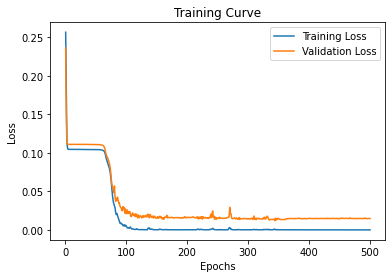

Training Completed.
0.9294532627865961
[[63  0  0  0  0  0  0  0  0]
 [ 0 57  0  6  0  0  0  0  0]
 [ 0  3 59  0  0  0  0  1  0]
 [ 0  0  0 52  5  4  0  2  0]
 [ 0  0  0  0 63  0  0  0  0]
 [ 0  0  0  0  0 63  0  0  0]
 [ 0  2  5  0  0  0 55  1  0]
 [ 0  1  4  0  0  0  1 57  0]
 [ 0  5  0  0  0  0  0  0 58]]


In [ ]:
model1 = pnet(40,6,False,216,54,True,9)  ## 1st
model1 = training(model1,0.1,500,64,'MSE',0.9,SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val),True,True,SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),False)
accu, conf = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print(accu)
print(conf)

In [ ]:
accu1, conf1 = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
print(conf1+conf2)
print(np.trace(conf1+conf2)/np.sum(conf1+conf2))

[[125   0   0   0   0   0   0   0   0]
 [  0 115   0  10   0   0   0   0   0]
 [  0   5 119   0   0   0   0   1   0]
 [  0   0   0 105   7   7   0   6   0]
 [  0   0   0   0 125   0   0   0   0]
 [  0   0   1   0   0 124   0   0   0]
 [  0   2  10   0   0   0 112   1   0]
 [  0   3   9   0   0   1   1 111   0]
 [  0  11   0   0   0   0   0   0 114]]
0.9333333333333333


Data Setup Started
Data Setup Completed
Building model


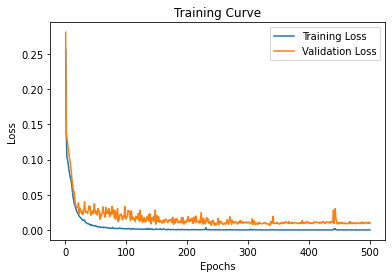

Training Completed.
for session: 0
[[50  0  0  0  0  0  0  0  0]
 [ 0 49  1  0  0  0  0  0  0]
 [ 4  0 46  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  2  0 48  0  0]
 [ 0  5  5  0  0  0  0 40  0]
 [ 0  0  0  0  5  0  0  0 45]]
0.9511111111111111
Data Setup Started
Data Setup Completed
Building model


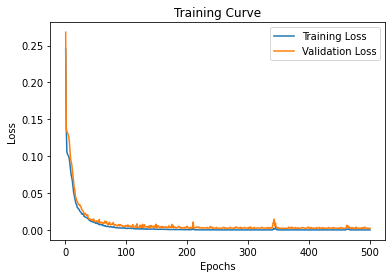

Training Completed.
for session: 1
[[48  0  2  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0]
 [ 6  0 44  0  0  0  0  0  0]
 [ 0  0  0 49  0  0  0  1  0]
 [ 0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50]]
0.98
Data Setup Started
Data Setup Completed
Building model


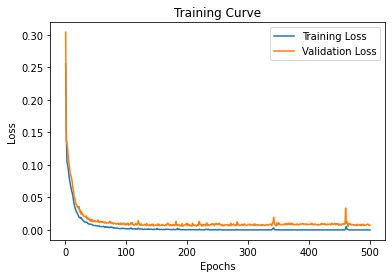

Training Completed.
for session: 4
[[50  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0]
 [ 2  0 48  0  0  0  0  0  0]
 [ 0  0  0 48  0  0  0  0  2]
 [ 0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0 50  0  0]
 [ 0  0  1  1  0  0  0 46  2]
 [ 0  0  0  9  0  0  0  0 41]]
0.9622222222222222
Data Setup Started
Data Setup Completed
Building model


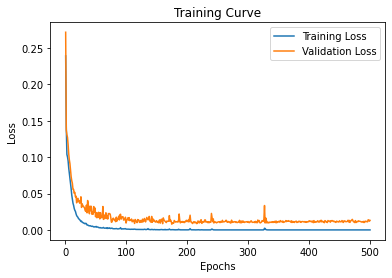

Training Completed.
for session: 7
[[41  0  9  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0]
 [ 1  1 47  0  0  0  0  1  0]
 [ 0  0  6 43  0  0  0  1  0]
 [ 0  0  0  1 48  0  1  0  0]
 [ 0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50]]
0.9533333333333334
Data Setup Started
Data Setup Completed
Building model


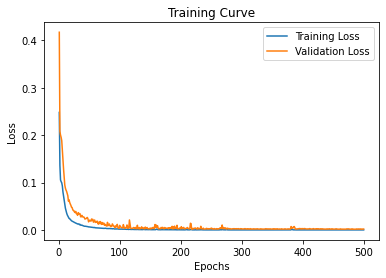

Training Completed.
for session: 13
[[24  0  1  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0 25  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  1  0  0  0 24]]
0.9911111111111112
Data Setup Started
Data Setup Completed
Building model


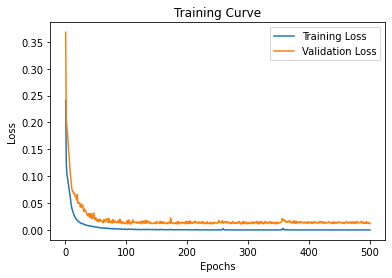

Training Completed.
for session: 14
[[25  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0]
 [ 1  0 23  1  0  0  0  0  0]
 [ 0  0  1 23  0  0  0  0  1]
 [ 0  0  0  0 23  0  0  0  2]
 [ 0  0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0 25]]
0.9733333333333334


In [63]:
sessions = [0,1,4,7,13,14]
conf_list = []
remove_gest=[3,10]
for session in sessions:
  X_train, y_train = get_prune_data_session(True,40,remove_gest,session)
  X_test_use, y_test_use = get_prune_data_session(False,40,remove_gest,session)
  X_test,X_val,y_test,y_val = get_test_val(X_test_use,y_test_use,[0,2])
  model1 = model1 = pnet(40,6,False,216,54,True,9)  ## 1st
  model1 = training(model1,0.0003,500,64,'MSE',0.9,SoliData('Train',X_train,y_train,X_test,y_test,X_val,y_val),True,False,SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),False)
  accu1, conf1 = testing_conf(SoliData('Test',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
  accu2, conf2 = testing_conf(SoliData('Val',X_train,y_train,X_test,y_test,X_val,y_val),model1,device,'MSE')
  print("for session: " + str(session))
  print(conf1+conf2)
  print(np.trace(conf1+conf2)/np.sum(conf1+conf2))
  conf_list.append((conf1+conf2))

In [64]:
total_conf = None
for i in range(len(conf_list)):
  if i==0:
    total_conf = conf_list[i]
  else:
    total_conf += conf_list[i]

print(total_conf)
print(np.trace(total_conf)/np.sum(total_conf))

[[238   0  12   0   0   0   0   0   0]
 [  0 249   1   0   0   0   0   0   0]
 [ 14   1 233   1   0   0   0   1   0]
 [  0   0   7 238   0   0   0   2   3]
 [  0   0   0   1 246   0   1   0   2]
 [  0   0   0   0   0 250   0   0   0]
 [  0   0   0   0   2   0 248   0   0]
 [  0   5   6   1   0   0   0 236   2]
 [  0   0   0   9   6   0   0   0 235]]
0.9657777777777777
